In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [4]:
# Normalize and flatten images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [6]:
# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [7]:
# Define the CVAE architecture
original_dim = 28 * 28
latent_dim = 2
intermediate_dim = 256
epochs = 3
batch_size = 128

In [10]:
# Encoder
x = Input(shape=(original_dim,))
label = Input(shape=(10,))
inputs = Concatenate(axis=-1)([x, label])
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


In [11]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Conditional VAE Model
cvae = Model([x, label], x_decoded_mean)

# Decoder Model
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 256)               768       
                                                                 
 dense_10 (Dense)            (None, 784)               201488    
                                                                 
Total params: 202256 (790.06 KB)
Trainable params: 202256 (790.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Custom loss function
xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
cvae_loss = K.mean(xent_loss + kl_loss)

cvae.add_loss(cvae_loss)
cvae.compile(optimizer='rmsprop')

In [13]:
# Training
cvae.fit([x_train, y_train], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=([x_test, y_test], None))

Epoch 1/3
469/469 [==============================] - 4s 8ms/step - loss: 194.4381 - val_loss: 173.9673
Epoch 2/3
469/469 [==============================] - 3s 7ms/step - loss: 170.9347 - val_loss: 168.9853
Epoch 3/3
469/469 [==============================] - 3s 7ms/step - loss: 167.5383 - val_loss: 166.3852


1/1 [==============================] - 0s 21ms/step


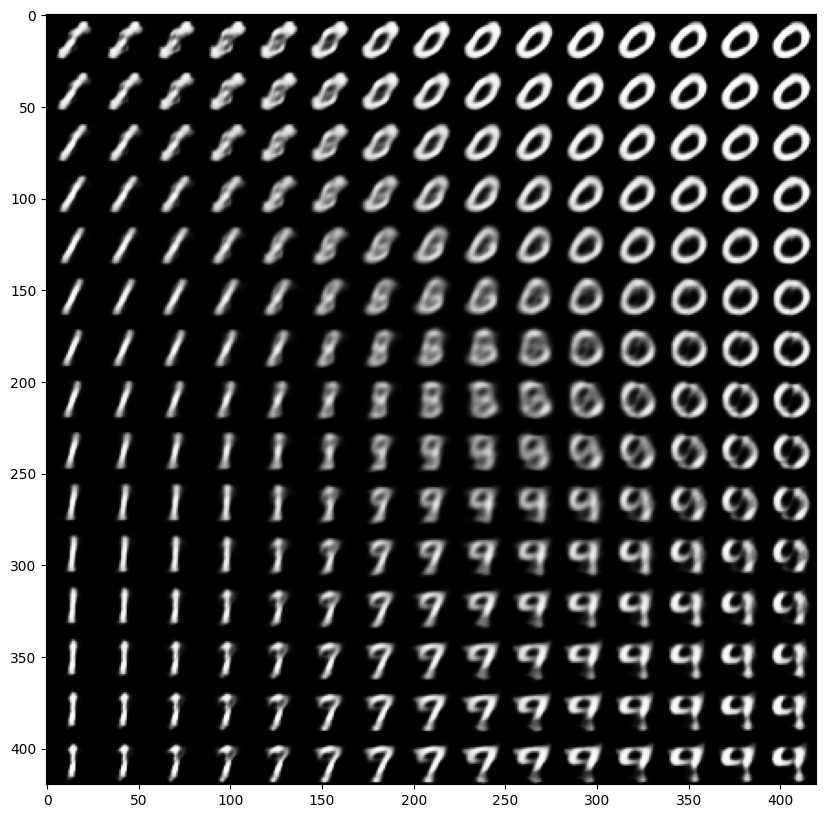

In [14]:
# Generate new samples
n = 15  # Number of images to generate
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Linearly spaced coordinates on the unit square
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        label_sample = np.zeros((1, 10))
        label_sample[0,3] = 1  # Choose a specific label (e.g., digit 7)
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()